In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
%matplotlib

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
sys.path.insert(0, eyefuncdir)
import eyefuncs as eyes
from funcs import clusterperm_test

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26])
nsubs = subs.size

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'times_500hz.npy')), 3)
eyetimes   = np.round(np.load(op.join(wd, 'data', 'glms', '500hz', 'no_smoothing', 'eye_glm', 'eyetracker_times.npy')), 2)
regnames   = np.load(op.join(wd, 'data', 'glms', '500hz', 'no_smoothing', 'eye_glm', 'regressor_names.npy'))

nparams = regnames.size
#ppts x tuning curve timepoints x regressors x
b = np.zeros(shape = [nsubs, nparams, modeltimes.size, eyetimes.size]) * np.nan
t = np.zeros(shape = [nsubs, nparams, modeltimes.size, eyetimes.size]) * np.nan

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
use_b = True
if use_b:
    paramind = 0
    addtext = 'modelAmplitudeBeta'
elif not use_b:
    paramind = 1
    addtext = 'modelAmplitudeTvalue'
fittype = 'glm'
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'

subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', '500hz', 'no_smoothing', 'eye_glm', f'wmc_s{sub:02d}_glm3_betas_{fittext}_{addtext}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', '500hz', 'no_smoothing', 'eye_glm', f'wmc_s{sub:02d}_glm3_tvalues_{fittext}_{addtext}.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants
tm = np.nanmean(t, axis=0)

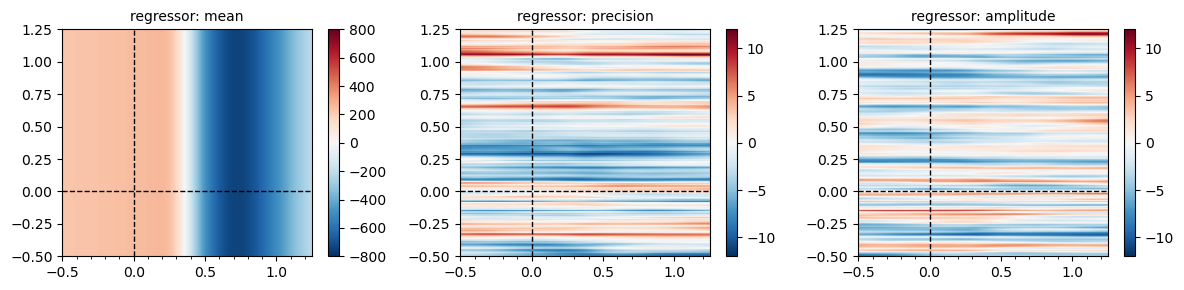

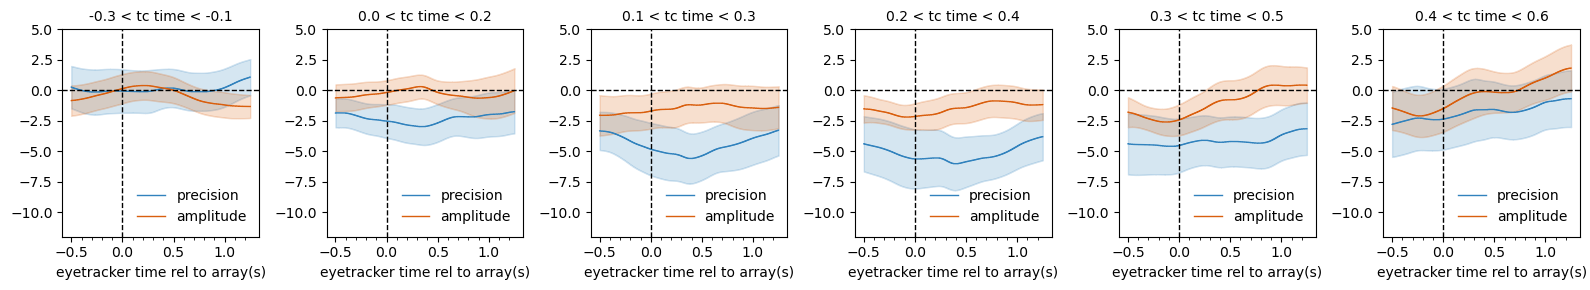

In [3]:
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -800, 800
    else:
        vmin, vmax = -12, 12
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(bm[iparam].squeeze(), aspect= 'auto', interpolation='none', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eyetimes.min(), eyetimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = b[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eyetimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eyetimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    ax.set_ylim([-12, 5])
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.set_xlabel('eyetracker time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'lower right', frameon=False)
fig.tight_layout()

Using a threshold of -1.753050
stat_fun(H1): min=-2.3479776379225585 max=1.833967320918847
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 26461.02it/s]


cluster p-values for precision regressor: [0.371  0.2865]
Using a threshold of -1.753050
stat_fun(H1): min=-2.3527353085737257 max=1.8155008886141633
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 25068.38it/s]


cluster p-values for precision regressor: [0.3935 0.3466]
Using a threshold of -1.753050
stat_fun(H1): min=-2.3259263321562136 max=1.773464790372556
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 9999/9999 [00:00<00:00, 26085.54it/s]


cluster p-values for precision regressor: [0.3748 0.3239]


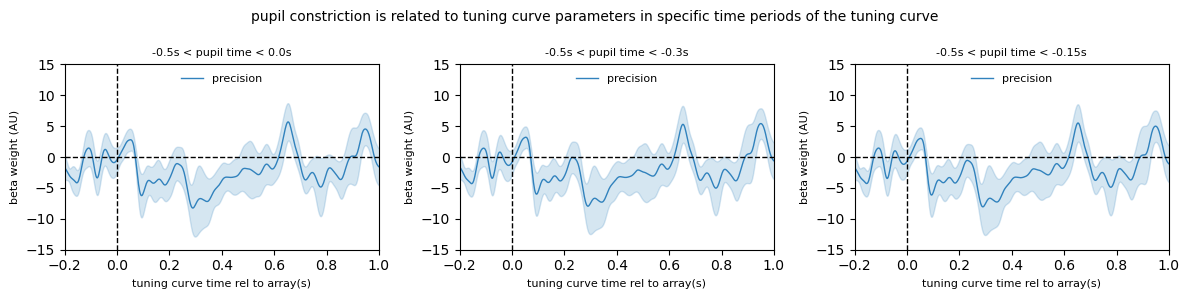

In [7]:
#params for cluster forming
alpha = 0.05
t_thresh = sp.stats.t.ppf(1-alpha, df = nsubs-1)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing
nperms = 10000
smoothsig = 5


mstarts = [-0.5, -0.5,  -0.5]
mends   = [0.0, -0.3, -0.15]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
labs = ['precision', 'amplitude']
fig = plt.figure(figsize = [nplots*4, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eyetimes >= istart, eyetimes <= iend)
    idat = b[:,:,:,tinds].mean(-1)
    idat = sp.ndimage.gaussian_filter1d(idat, sigma = smoothsig)
    for ireg in range(2):
        if labs[ireg] == 'precision':
            # plotd = b[:,:,:,tinds].mean(-1)
            plotd = idat[:,ireg+1] #take just the relevant parameter
            plotm = plotd.mean(axis=0) #average across participants
            plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
        
            ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
            ax.fill_between(modeltimes,
                            np.add(plotm, plotsem),
                            np.subtract(plotm, plotsem),
                            edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < pupil time < {iend}s', fontsize = 8)
    ax.set_ylim([-15, 15])
    ax.set_xlim([-0.2, 1])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)

    #run cluster permutation stats
    for reg in ['precision']:#, 'amplitude']:
        if reg == 'precision':
            icol = '#3182bd'
            ih = -14
        elif reg == 'amplitude':
            icol = '#d95f0e'
            ih = -15
        tv, clu, clupv, _ = clusterperm_test(data = idat,
                                        labels = regnames, of_interest = reg, times = modeltimes,
                                        tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = nperms, #run all possible permutations (exact permutation test)
                                        threshold = None, tail = -1, #one-tailed
                                        n_jobs=4)
        clu = [x[0] for x in clu]
        print(f'cluster p-values for {reg} regressor: {clupv}')
        times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
        nclus = len(clu)
        for icluster in range(nclus):
            mask = clu[icluster]
            if clupv[icluster] <= alpha:
                itmin = times_twin[mask[0]]
                itmax = times_twin[mask[-1]]
                ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
        
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.suptitle('pupil constriction is related to tuning curve parameters in specific time periods of the tuning curve', fontsize = 10)
fig.tight_layout()

<font color='blue'>

same but with t-values from each participant instead of beta values

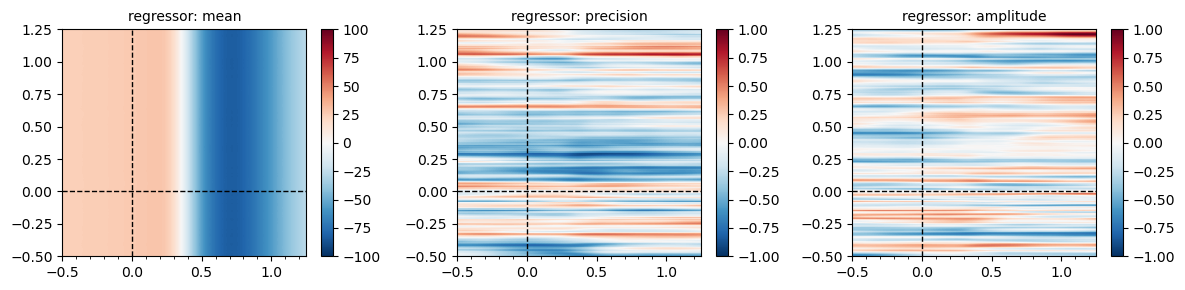

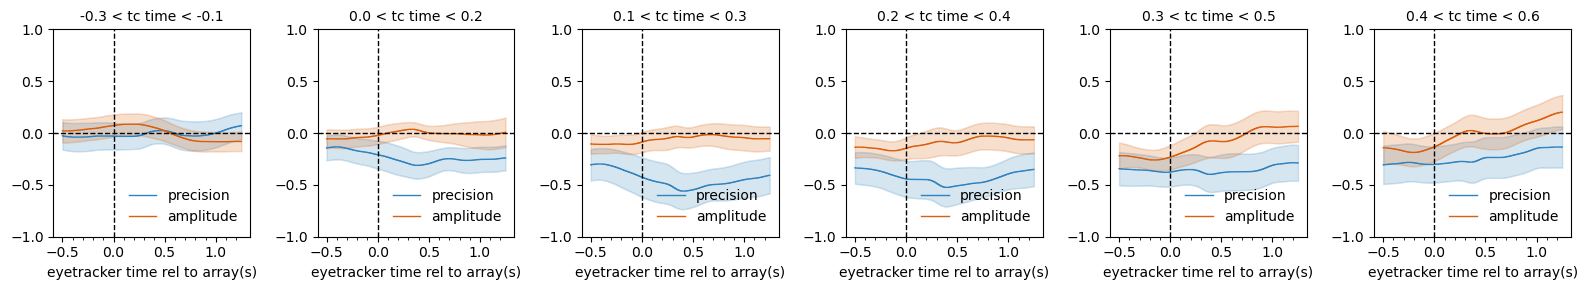

In [5]:
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -100, 100
    else:
        vmin, vmax = -1, 1
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(tm[iparam].squeeze(), aspect= 'auto', interpolation='none', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eyetimes.min(), eyetimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = t[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eyetimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eyetimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    ax.set_ylim([-1, 1])
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.set_xlabel('eyetracker time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'lower right', frameon=False)
fig.tight_layout()

stat_fun(H1): min=-2.7831310300516345 max=2.1613537050308356
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 23186.94it/s]


cluster p-values for precision regressor: [0.60448615 0.31488518 0.26584268 0.62911421]
stat_fun(H1): min=-2.7583358004789784 max=2.3881949143700436
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 22517.52it/s]


cluster p-values for precision regressor: [0.63848325 0.35738155 0.38217746]
stat_fun(H1): min=-2.744827616837683 max=2.2717550441156544
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:03<00:00, 20581.68it/s]


cluster p-values for precision regressor: [0.61438926 0.33962005 0.32370489]


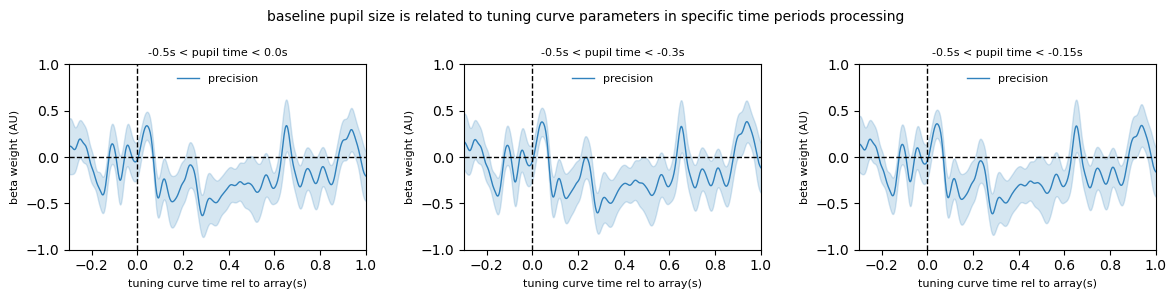

In [8]:
#params for cluster forming
sigalpha = 0.05
t_thresh = sp.stats.t.ppf(1-alpha, df = nsubs-1)
tmin, tmax = 0, 1 #time-window for cluster permutation testing
smoothsig = 5


mstarts = [-0.5, -0.5,  -0.5]
mends   = [0.0, -0.3, -0.15]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
labs = ['precision', 'amplitude']
fig = plt.figure(figsize = [nplots*4, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eyetimes >= istart, eyetimes <= iend)
    idat = t[:,:,:,tinds].mean(-1)
    idat = sp.ndimage.gaussian_filter1d(idat, sigma = smoothsig)
    for ireg in range(2):
        if labs[ireg] == 'precision':
            plotd = idat[:,ireg+1] #take just the relevant parameter
            plotm = plotd.mean(axis=0) #average across participants
            plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
        
            ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
            ax.fill_between(modeltimes,
                            np.add(plotm, plotsem),
                            np.subtract(plotm, plotsem),
                            edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < pupil time < {iend}s', fontsize = 8)
    ax.set_ylim([-1, 1])
    ax.set_xlim([-0.3, 1])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)

    #run cluster permutation stats
    for reg in ['precision']:#, 'amplitude']:
        if reg == 'precision':
            icol = '#3182bd'
            ih = -0.8
        elif reg == 'amplitude':
            icol = '#d95f0e'
            ih = -0.9
        tv, clu, clupv, _ = clusterperm_test(data = idat,
                                        labels = regnames, of_interest = reg, times = modeltimes,
                                        tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = 'all', #run all possible permutations (exact permutation test)
                                        threshold = -t_thresh, tail = -1, #one-tailed
                                        n_jobs=4)
        clu = [x[0] for x in clu]
        print(f'cluster p-values for {reg} regressor: {clupv}')
        times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
        nclus = len(clu)
        for icluster in range(nclus):
            mask = clu[icluster]
            if clupv[icluster] <= sigalpha:
                itmin = times_twin[mask[0]]
                itmax = times_twin[mask[-1]]
                ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.suptitle('baseline pupil size is related to tuning curve parameters in specific time periods processing', fontsize = 10)
fig.tight_layout()